In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import kagglehub


2025-04-11 17:45:30.456098: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 17:45:30.475829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744386330.489120  103621 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744386330.492812  103621 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744386330.506400  103621 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:

path = kagglehub.dataset_download("kmldas/insect-identification-from-habitus-images")

print("Path to dataset files:", path)

100%|██████████| 2.38G/2.38G [01:04<00:00, 39.9MB/s]

Extracting files...


Path to dataset files: /home/maiko/.cache/kagglehub/datasets/kmldas/insect-identification-from-habitus-images/versions/1


In [2]:
target_dir = "./data/insects"

In [4]:
target_dir = "./data/insects"

!mkdir -p {target_dir}
!mv {path}/* {target_dir}/

print(f"Files moved to: {target_dir}")


Files moved to: ./data/insects


In [3]:
import os
import shutil
import random

def split_dataset(data_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42):
    """
    Split dataset into train, validation, and test sets
    
    Parameters:
    - data_dir: Root directory containing image folders
    - train_ratio: Proportion of data for training (default 0.7)
    - val_ratio: Proportion of data for validation (default 0.15)
    - test_ratio: Proportion of data for testing (default 0.15)
    - random_seed: Random seed for reproducibility
    """
    # Set random seed for reproducibility
    random.seed(random_seed)
    
    # Create train, validation, and test directories
    train_dir = os.path.join(data_dir, 'train')
    validation_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')
    
    # Create directories if they don't exist
    for dir_path in [train_dir, validation_dir, test_dir]:
        os.makedirs(dir_path, exist_ok=True)
    
    # Walk through the database directory
    database_path = os.path.join(data_dir, 'database')
    
    # Keep track of how many images we've processed
    total_images_processed = 0
    
    # Iterate through each class (subfolder in database)
    for class_folder in os.listdir(database_path):
        class_path = os.path.join(database_path, class_folder)
        
        # Skip if not a directory
        if not os.path.isdir(class_path):
            continue

        
        # Create corresponding class directories in train, val, and test
        for split_dir in [train_dir, validation_dir, test_dir]:
            os.makedirs(os.path.join(split_dir, class_folder), exist_ok=True)
        
        # Get all image files in the class folder
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        
        # Shuffle the images
        random.shuffle(image_files)
        
        # Calculate split indices
        total_images = len(image_files)
        train_split = int(total_images * train_ratio)
        val_split = train_split + int(total_images * val_ratio)
        
        # Split and move images
        train_images = image_files[:train_split]
        val_images = image_files[train_split:val_split]
        test_images = image_files[val_split:]
        
        # Copy images to respective directories
        splits = [
            (train_images, train_dir),
            (val_images, validation_dir),
            (test_images, test_dir)
        ]
        
        for image_list, dest_dir in splits:
            for image_file in image_list:
                src_path = os.path.join(class_path, image_file)
                dest_path = os.path.join(dest_dir, class_folder, image_file)
                shutil.copy(src_path, dest_path)
        
        total_images_processed += total_images
        print(f"Processed class {class_folder}: {total_images} images")
    
    print(f"\nTotal images processed: {total_images_processed}")
    print("Dataset split completed!")


data_dir = target_dir  
split_dataset(data_dir)

# Verify the split
def count_images_in_split(split_dir):
    total_images = 0
    for class_folder in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_folder)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            total_images += len(images)
            print(f"{class_folder}: {len(images)} images")
    return total_images

print("\nTraining set:")
train_count = count_images_in_split(os.path.join(data_dir, 'train'))
print("\nValidation set:")
val_count = count_images_in_split(os.path.join(data_dir, 'val'))
print("\nTest set:")
test_count = count_images_in_split(os.path.join(data_dir, 'test'))

print(f"\nTotal images: {train_count + val_count + test_count}")

Processed class 5755451: 203 images
Processed class 8236590: 87 images
Processed class 6097878: 376 images
Processed class 6097871: 176 images
Processed class 7856746: 316 images
Processed class 5755296: 214 images
Processed class 1035208: 194 images
Processed class 4473795: 208 images
Processed class 1035167: 213 images
Processed class 1036893: 472 images
Processed class 5873214: 119 images
Processed class 4475908: 205 images
Processed class 4472929: 142 images
Processed class 6097926: 82 images
Processed class 5755060: 322 images
Processed class 5755293: 83 images
Processed class 6097857: 193 images
Processed class 6097923: 116 images
Processed class 6097886: 162 images
Processed class 5755339: 314 images
Processed class 5872954: 114 images
Processed class 4988484: 444 images
Processed class 4475846: 137 images
Processed class 5872127: 316 images
Processed class 6097890: 121 images
Processed class 4475157: 57 images
Processed class 5756015: 123 images
Processed class 5755562: 61 imag

In [4]:
import os

# List files and folders in the target directory
for root, dirs, files in os.walk(target_dir):
    print(f"\n📁 {root}")
    for d in dirs:
        print(f"  └── 📂 {d}")
    for f in files[:5]: 
        print(f"  └── 📄 {f}")



📁 ./data/insects
  └── 📂 val
  └── 📂 database
  └── 📂 train
  └── 📂 test

📁 ./data/insects/val
  └── 📂 5755451
  └── 📂 8236590
  └── 📂 6097878
  └── 📂 6097871
  └── 📂 7856746
  └── 📂 5755296
  └── 📂 1035208
  └── 📂 4473795
  └── 📂 1035167
  └── 📂 1036893
  └── 📂 5873214
  └── 📂 4475908
  └── 📂 4472929
  └── 📂 6097926
  └── 📂 5755060
  └── 📂 5755293
  └── 📂 6097857
  └── 📂 6097923
  └── 📂 6097886
  └── 📂 5755339
  └── 📂 5872954
  └── 📂 4988484
  └── 📂 4475846
  └── 📂 5872127
  └── 📂 6097890
  └── 📂 4475157
  └── 📂 5756015
  └── 📂 5755562
  └── 📂 4473297
  └── 📂 4308787
  └── 📂 6097879
  └── 📂 5753697
  └── 📂 5755075
  └── 📂 5872109
  └── 📂 4475685
  └── 📂 7792354
  └── 📂 4475181
  └── 📂 4308805
  └── 📂 5873271
  └── 📂 4472884
  └── 📂 7727698
  └── 📂 5755051
  └── 📂 1035231
  └── 📂 6097869
  └── 📂 1035551
  └── 📂 1036154
  └── 📂 4476667
  └── 📂 4308812
  └── 📂 4473974
  └── 📂 4479890
  └── 📂 5756374
  └── 📂 5757310
  └── 📂 1035366
  └── 📂 5753757
  └── 📂 9252314
  └── 📂 4475179
  └── 📂 

In [5]:
data_dir = target_dir


train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Print paths to verify
print(f"Training directory: {train_dir}")
print(f"Validation directory: {validation_dir}")
print(f"Test directory: {test_dir}")

# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation generator (no augmentation, just preprocessing)
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Test generator (no augmentation, just preprocessing)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Set up parameters
img_height, img_width = 299, 299  # InceptionV3 input size
batch_size = 32

# Create training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create validation generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Print number of classes and samples
print(f"Number of classes: {train_generator.num_classes}")
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")

# Let's also check the class names/indices mapping
class_indices = train_generator.class_indices
print("\nClass mapping:")
for class_name, index in class_indices.items():
    print(f"{index}: {class_name}")


Training directory: ./data/insects/train
Validation directory: ./data/insects/val
Test directory: ./data/insects/test
Found 44216 images belonging to 291 classes.
Found 9365 images belonging to 291 classes.
Found 9783 images belonging to 291 classes.
Number of classes: 291
Number of training samples: 44216
Number of validation samples: 9365
Number of test samples: 9783

Class mapping:
0: 1035167
1: 1035185
2: 1035194
3: 1035195
4: 1035204
5: 1035208
6: 1035231
7: 1035290
8: 1035366
9: 1035434
10: 1035542
11: 1035551
12: 1035578
13: 1035864
14: 1035929
15: 1035931
16: 1036066
17: 1036128
18: 1036154
19: 1036192
20: 1036203
21: 1036216
22: 1036255
23: 1036286
24: 1036789
25: 1036796
26: 1036893
27: 1036899
28: 1036917
29: 1036958
30: 1037293
31: 1037319
32: 1037633
33: 4308786
34: 4308787
35: 4308789
36: 4308790
37: 4308800
38: 4308801
39: 4308804
40: 4308805
41: 4308806
42: 4308807
43: 4308811
44: 4308812
45: 4308815
46: 4470539
47: 4470555
48: 4470765
49: 4470801
50: 4471071
51: 447111

I0000 00:00:1744386426.339118  103621 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


Training top layers only...


/home/maiko/miniconda3/envs/cvai/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1744386430.984690  104230 service.cc:152] XLA service 0x7f98c40050d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744386430.984718  104230 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-04-11 17:47:11.066920: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744386432.055704  104230 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-11 17:47:13.004926: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8408_0', 4 bytes spill stores, 4 bytes spill loads

2025-04-11 17:47:13.006957: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8401'

   1/1381 ━━━━━━━━━━━━━━━━━━━━ 4:23:09 11s/step - accuracy: 0.0000e+00 - loss: 5.7005

I0000 00:00:1744386439.935632  104230 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 225/1381 ━━━━━━━━━━━━━━━━━━━━ 4:15 221ms/step - accuracy: 0.0439 - loss: 5.3053

2025-04-11 17:48:11.187962: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8401', 8 bytes spill stores, 8 bytes spill loads

2025-04-11 17:48:11.249386: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8401', 4 bytes spill stores, 4 bytes spill loads

2025-04-11 17:48:11.259646: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8401', 220 bytes spill stores, 220 bytes spill loads

2025-04-11 17:48:11.259727: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8408', 148 bytes spill stores, 148 bytes spill loads

2025-04-11 17:48:11.498919: I external/l

1381/1381 ━━━━━━━━━━━━━━━━━━━━ 337s 236ms/step - accuracy: 0.1376 - loss: 4.1967 - val_accuracy: 0.3348 - val_loss: 2.5857
Epoch 2/10
   1/1381 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.3750 - loss: 2.9348

/home/maiko/miniconda3/envs/cvai/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1381/1381 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3750 - loss: 2.9348 - val_accuracy: 0.3440 - val_loss: 2.5507
Epoch 3/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 313s 226ms/step - accuracy: 0.3717 - loss: 2.3897 - val_accuracy: 0.4195 - val_loss: 2.1282
Epoch 4/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5312 - loss: 1.6591 - val_accuracy: 0.4229 - val_loss: 2.1109
Epoch 5/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 311s 226ms/step - accuracy: 0.4410 - loss: 2.0217 - val_accuracy: 0.4320 - val_loss: 2.0442
Epoch 6/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5312 - loss: 1.7753 - val_accuracy: 0.4300 - val_loss: 2.0453
Epoch 7/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 314s 227ms/step - accuracy: 0.4865 - loss: 1.8313 - val_accuracy: 0.4785 - val_loss: 1.8499
Epoch 8/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6250 - loss: 1.4480 - val_accuracy: 0.4788 - val_loss: 1.8490
Epoch 9/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 312s 226ms/step - accuracy: 0.5087 - loss: 

2025-04-11 18:14:31.613038: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10848_0', 204 bytes spill stores, 420 bytes spill loads

2025-04-11 18:14:31.696775: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10848', 84 bytes spill stores, 84 bytes spill loads

2025-04-11 18:14:31.778715: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10848', 4 bytes spill stores, 4 bytes spill loads



  55/1381 ━━━━━━━━━━━━━━━━━━━━ 4:46 216ms/step - accuracy: 0.3008 - loss: 2.9413

2025-04-11 18:14:49.226584: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10848', 4 bytes spill stores, 4 bytes spill loads

2025-04-11 18:14:49.236861: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10848', 8 bytes spill stores, 8 bytes spill loads

2025-04-11 18:14:49.250477: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10848_0', 204 bytes spill stores, 444 bytes spill loads



1381/1381 ━━━━━━━━━━━━━━━━━━━━ 328s 230ms/step - accuracy: 0.5202 - loss: 1.7364 - val_accuracy: 0.6681 - val_loss: 1.1010
Epoch 2/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6562 - loss: 1.2530 - val_accuracy: 0.6694 - val_loss: 1.1008
Epoch 3/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 310s 225ms/step - accuracy: 0.6765 - loss: 1.0722 - val_accuracy: 0.7009 - val_loss: 0.9767
Epoch 4/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7188 - loss: 0.8469 - val_accuracy: 0.7002 - val_loss: 0.9801
Epoch 5/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 309s 224ms/step - accuracy: 0.7158 - loss: 0.9201 - val_accuracy: 0.7223 - val_loss: 0.8989
Epoch 6/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7500 - loss: 0.6964 - val_accuracy: 0.7225 - val_loss: 0.9002
Epoch 7/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 9752s 7s/step - accuracy: 0.7467 - loss: 0.8038 - val_accuracy: 0.7317 - val_loss: 0.8890
Epoch 8/10
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6250 - loss: 1.1

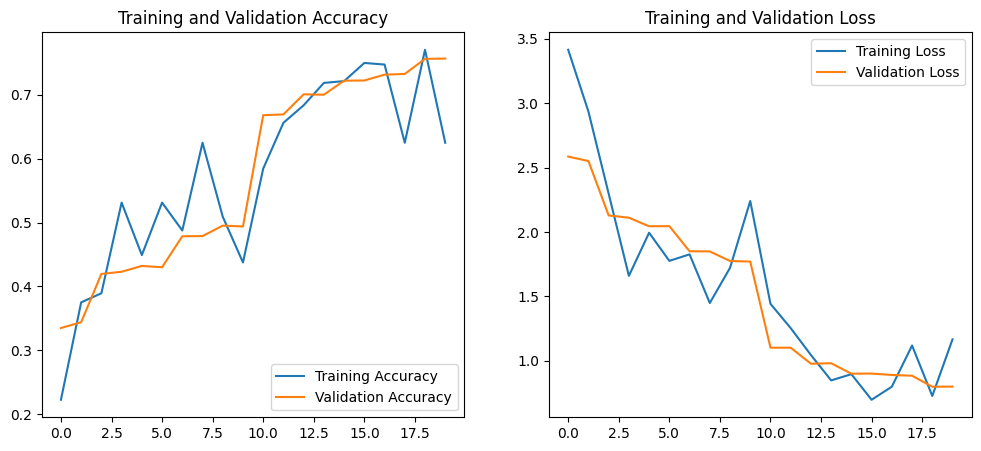

Fine-tuning complete. Model saved as 'plant_finetuned_inceptionv3.h5'


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# Add a final output layer with softmax for classification
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

# First, freeze all base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with frozen base layers
print("Training top layers only...")
history_1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Now unfreeze some of the top layers of the base model
# Unfreeze the last 2 inception blocks
for layer in model.layers:
    layer.trainable = True
    
fine_tune_at = -50  # Approximately the last 2 InceptionV3 blocks
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

for i, layer in enumerate(model.layers[fine_tune_at:]):
    print(f"Layer {i + fine_tune_at}: {layer.name} - Trainable: {layer.trainable}")
    
# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])


print("Fine-tuning the model...")
history_2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Save the fine-tuned model
model.save('insect_finetuned_inceptionv3.h5')

# Plot training history
def plot_training_history(history_1, history_2):
    # Combine histories
    acc = history_1.history['accuracy'] + history_2.history['accuracy']
    val_acc = history_1.history['val_accuracy'] + history_2.history['val_accuracy']
    loss = history_1.history['loss'] + history_2.history['loss']
    val_loss = history_1.history['val_loss'] + history_2.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(history_1, history_2)

print("Fine-tuning complete. Model saved as 'plant_finetuned_inceptionv3.h5'")